# WOFOST for Data Science Workshop

This is a workshop to understand the important characteristics and functioning of the WOFOST model through its Python implementation in PCSE, from a data science perspective.

### Get this notebook

Open you terminal on a directory where you can download the repository that contains this workshop. THen, follow the steps:

1. Clone this repo 

```shell
$ git clone https://github.com/rogerioagjr/wofost-workshop.git
```

2. Install jupyter and statsmodels, if you do not have it already

```shell
$ pip install jupyter
$ pip install statsmodels
```

3. Open the cloned directory and launch this notebook

```shell
$ cd wofost-workshop
$ jupyter notebook
```

## What I expect you to know

* Python
    * Matplotlib
    * Pandas

## WOFOST Overview

A quick overview of what the WOFOST model is

### A crop as a dynamical system

* Models the growth of a homogeneous crop over time, given initial conditions, as a dynamical system

* Model Input:
    * Crop parameters
        * Set of variables that define a specific crop
    * Soil and Site parameters
        * Set of variables that define a specific soil
    * Weather
        * Daily weather observations
        
* WOFOST creates a physical model of the crop and the soil and simulates the evolution of this model thorough time

* In each day, the model will be in a new state and will output the parameters that define this state: the current state of the crop and the soil

* New state ${\bf s}_t = {\bf s}_{t-1} + \Delta {\bf s}_t$
    * $\Delta {\bf s}_t$ is calculated using the internal parameters and weather information for day $t$
    
### Potential vs Actual

* The **Defining Factors** are used to calculate the **potential** state of a crop on each day
    * Defining Factors: CO$_2$, Radiation, Tempearature, Crop Features
* The **Limiting Factors** are used to calculate the **attainable yield**, *i.e.*, how far from the potential yield the crop will be
    * Limiting Factors: availability of water and nutrients in soil
    
### More information on the functioning of WOFOST

Manual, reference guides, presentations, and publicatiosn about or using WOFOST can be found on: 

https://www.wur.nl/en/Research-Results/Research-Institutes/Environmental-Research/Facilities-Products/Software-models-and-databases/WOFOST/Documentation-WOFOST.htm

## The PCSE Package

Python implementation of WOFOST

Can be found on: https://pcse.readthedocs.io

### Installing PCSE

#### Install Miniconda

1. Open http://conda.pydata.org/miniconda.html

2. Download the most recent Python 3.x version

3. Check that installation works typing the following command in the shell

```shell
$ conda list
```

#### Install PCSE

Runn the following commands in the shell

```shell
$ conda env create -f py3_pcse.yml
$ activate py3_pcse
$ pip install pcse
```

#### Launching PCSE

Now, close this notebook and launch it again from the new conda environment. Then, test whether PCSE is working properly:

In [ ]:
import pcse
pcse.test()

## Creating a WOFOST simulation 

Now, let us follow the steps to run a simulation. First, let us import the relevant packages for this workshop.

In [ ]:
from pcse.fileinput import CABOFileReader
from pcse.base import ParameterProvider
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.engine import Engine

import yaml
import os

### Defining Input Files

Here you can define the input files for your static simulation and the directory where they can be found.

It is important that these files be all in the same directory and that you provide the **absolute** path to this directory in *data_dir*.

Most files have their type specified in the comment. The *config* file is a text file with information regarding the variables and the model in the environment simulation. *WLP_NPK* is a configuration for a simulation that is sensible to water scarcity (a *Water-limited Production*) and to nutrient scarcity (*N, P, and K*).

In [ ]:
crop_file_name = "crop.cab" # Must be a CABO file
soil_file_name = "soil.cab" # Must be a CABO file
site_file_name = "site.cab" # Must be a CABO file
agro_file_name = "agro.yaml" # Must be a YAML file
weather_file_name = "weather.xlsx" # Must be a XLSx file
config_file_name = "WLP_NPK.conf"
data_dir = os.path.join(os.getcwd(), 'data')

In [ ]:
# This is the initialization of the WOFOST Simulation Environment
# Do not need to edit anything here.

crop = CABOFileReader(os.path.join(data_dir, crop_file_name))
soil = CABOFileReader(os.path.join(data_dir, soil_file_name))
site = CABOFileReader(os.path.join(data_dir, site_file_name))

parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
weatherdataprovider = ExcelWeatherDataProvider(os.path.join(data_dir, weather_file_name))
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
config = os.path.join(data_dir, config_file_name)

wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

## Simulation Results

Now you can convert the simulation results to a Pandas DataFrame, save them as a CSV file, and Plot them.

Here we have examples of the evolution of the Leaf Area Index (LAI), the Root Zone Soil Moisture (SM), the nutrients available, the weight of the total yield (which in this case is the Total Dry Weight of Storage Organs - TWSO), and the Development Index (a continuous and increasing variable that is 0 at seeding, 1 at flowering, and 2 at maturity)

In [ ]:
import pandas as pd

# Convert the simulation results to a DataFrame
# Save the DataFrame as a csv file

wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output())
df.to_csv('simulation_results.csv')
df = df.set_index("day")
df.tail()

## Variables Shown

We have a huge dataset with values for different crop and soil parameters during our simulated crop campaign. The variables to be outputted are defined in the configuration file (*WLP_NPK.conf*) and detailed descriptions of them can be found on WOFOST and PCSE documentation. 

From a data science perspective, we are not interested in the deep relations between the variables that define how the mechanism of simulation is done. What are some key variables that impact the crop that we should look at?

* Crop development
    * DVS: Development stage
    * TWSO: Total weight of storage organs (kg/ha)]
* Water Balance
    * SM: Volumetric moisture content in root zone
    * WWLOW: Total amount of water in the soil profile (cm)
* Nutrients Availability
    * NAVAIL: Total amount of available N (kg/ha)
    * PAVAIL: Total amount of available P (kg/ha)
    * KAVAIL: Total amount of available K (kg/ha)
    
We consider TWSO as a key variable because it can be seen as the yield, since the most important yield of a wheat crop are its storage organs (grains).

In [ ]:
key_params = ['DVS', 'TWSO', 'SM', 'WWLOW', 'NAVAIL', 'PAVAIL', 'KAVAIL']
df[key_params].tail()

## Plotting Important Variables

Given the important variables we want to track we can use matplotlib.

### Crop Development

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))                      # plot grid organization
df['DVS'].plot(ax=axes[1], title="Development Index")                           # DVS plot
df['TWSO'].plot(ax=axes[0], title="total dry weight of storage organs (kg/ha)") # TWSO plot
fig.autofmt_xdate()                                                             # rotate date labels

### Water Balance

Now, let us create two plots showing the soil moisture (SM) and total amount of water in soil (WWLOW)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

##### YOUR CODE HERE #####

# Plot Soil Moisture

# Plot Total Amount of Water

##########################

fig.autofmt_xdate()

### Nutrient Availability

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

##### YOUR CODE HERE #####

# Plot N Availability

# Plot P Availability

# Plot K Availability

##########################

fig.autofmt_xdate()

## Agromanagement Decisions

Now that you have understanding of what the simulation is and how to extract its outputs, let us begin to understand the inputs and how they modify the simulation. First, let us understand the impact of the agromanagement actions taken, *i.e.*, **irrigation** and **fertilization**.

To modify the agromanagement actions, we need to modify the agromanagement input file. Right now, it is the file *agro.yaml*. If you open it, you will see the following:

```YAML
Version: 1.0
AgroManagement:
- 2005-10-01:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2006-01-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
```

### Adding Irrigation

You can notice that there are no events specified, *i.e.*, no irrigation of fertilization actions. Let us try to introduce an irrigation action and see the changes it will make on the simulation.

If you open the file *agro-irrigate.yaml*, you will see the following:

```YAML
Version: 1.0
AgroManagement:
- 2005-10-01:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2006-01-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents:
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 2006-05-01: {amount: 10, efficiency: 0.7}
        - 2006-07-01: {amount: 15, efficiency: 0.7} 
    StateEvents: null
```

This file specifies two irrigation actions, one on May 1 and another on July 1. The irrigation amounts are specified in cm and the second irrigation is larger than the first. Let us run another simulation using *agro-irrigate.yaml* as the agromanagement input and compare the effects of the irrigation.

In [ ]:
agro_file_name = "agro-irrigate.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_irrigate = pd.DataFrame(wofost.get_output())
df_irrigate = df_irrigate.set_index("day")
df_irrigate[key_params].tail()

Let us compare the water balance in the soil with and without irrigation, plotting the two simulation outputs against each other using matplotlib.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Soil moisture in non irrigated simulation
df['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", label='Not Irrigated')

# Soil moisture in irrigated simulation
df_irrigate['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", label='Irrigated')
axes[0].legend()


##### YOUR CODE HERE #####

# Plot total amount of water

##########################

fig.autofmt_xdate()

As you can see, irrigating elevated the root zone soil moisture and the total water in the soil in the exact days in which irrigation was applied. 

However, did the irrigation affect the crop development? Let us plot and compare:

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df['DVS'].plot(ax=axes[0], title="Development Index", label='Not Irrigated')
df_irrigate['DVS'].plot(ax=axes[0], title="Development Index", label='Irrigated')
axes[0].legend()

# Plot the TWSO
df['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Not Irrigated')
df_irrigate['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Irrigated')
axes[1].legend()

fig.autofmt_xdate()

We can see that the irrigation did not affect the crop development.

* Water availability is only a **limniting factor**
* The fact that irrigation did not affect development means that in the non irrigated crop, water availability was not a limiting factor for the crop in achieving **potential yield**

### Adding Fertilization

Now, let us try to apply fertilization in the soil and see how it affects the crop development. We need to introduce a fertilization event in the agromanager.

If ypou open the file *agro-fertilize.yaml*, you will see the following:

```YAML
Version: 1.0
AgroManagement:
- 2005-10-01:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2006-01-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name: Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - 2006-04-01: {N_amount: 30, P_amount: 30, K_amount: 30, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
    StateEvents: null
```

Here, we try to fertilize the soil around the date in which we see a steep decline in nutrient availability in the first simulation. Let us provide this file as input and see how it modifies the simulation results.


In [ ]:
agro_file_name = "agro-fertilize.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_fertilize = pd.DataFrame(wofost.get_output())
df_fertilize = df_fertilize.set_index("day")
df_fertilize[key_params].tail()

It seems that it made a quite a big difference in yield!

Let us plot the crop development and see how it changed.

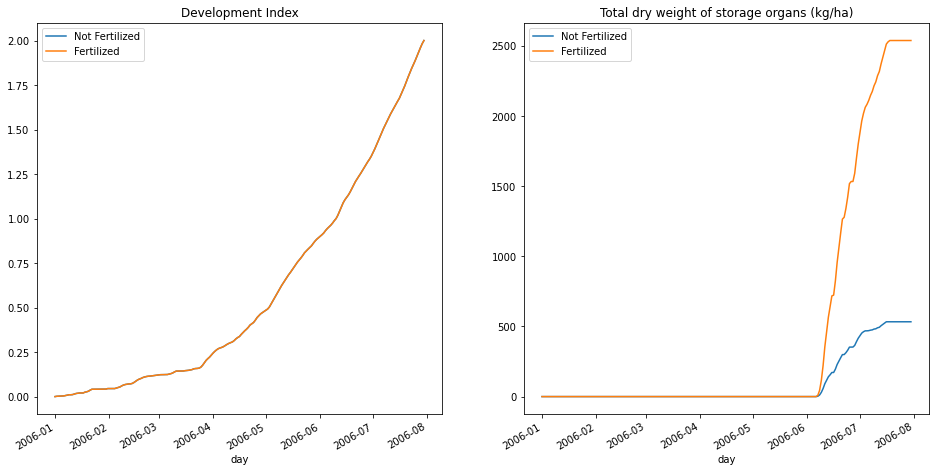

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df['DVS'].plot(ax=axes[0], title="Development Index", label='Not Fertilized')
df_fertilize['DVS'].plot(ax=axes[0], title="Development Index", label='Fertilized')
axes[0].legend()

# Plot the TWSO
df['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Not Fertilized')
df_fertilize['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Fertilized')
axes[1].legend()

fig.autofmt_xdate()

We can see that the total yield more than tripled!

Let us now plot the the nutrient availability in the soil and see the impact caused by fertilization.

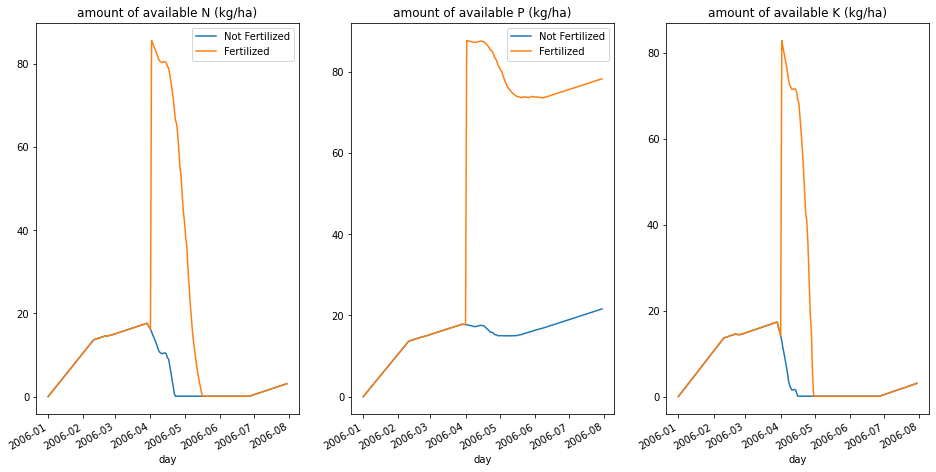

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Plot N Availability
df['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Not Fertilized')
df_fertilize['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Fertilized')
axes[0].legend()

# Plot P Availability
df['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Not Fertilized')
df_fertilize['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Fertilized')
axes[1].legend()

# Plot K Availability
df['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Not Fertilized')
df_fertilize['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Fertilized')
axes[0].legend()

fig.autofmt_xdate()

### More Fertilization

When we llok at the plots above, we can actually see that the levels of N and K still undergo a steep decline and reach a level of zero, which indicates the crop is completely using all tthe nutrients available in the soil. Thus, further fertilization could be helpful.

Let us add a second fertilization event, on April 15, and add more 75kg of N and K.

Open the file *agro-fertilize-more.yaml*, it will be an input identical to *agro-fertilize.yaml*. Add the second fertilization event to this file and feed it to the simulation.

In [16]:
agro_file_name = "agro-fertilize-more.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_fertilize_more = pd.DataFrame(wofost.get_output())
df_fertilize_more = df_fertilize_more.set_index("day")
df_fertilize_more[key_params].tail()

,DVS,TWSO,SM,WWLOW,NAVAIL,PAVAIL,KAVAIL
day,,,,,,,
2006-07-26,1.91155,8698.546847,0.353614,42.433645,60.229566,64.612278,2.730
2006-07-27,1.93765,8698.546847,0.352526,42.303175,60.320566,64.703278,2.821
2006-07-28,1.95970,8698.546847,0.352047,42.245640,60.411566,64.794278,2.912
2006-07-29,1.98220,8698.546847,0.352347,42.281658,60.502566,64.885278,3.003
2006-07-30,2.00000,8698.546847,0.351097,42.131593,60.593566,64.976278,3.094


Again, let us plot the yield and see the difference!

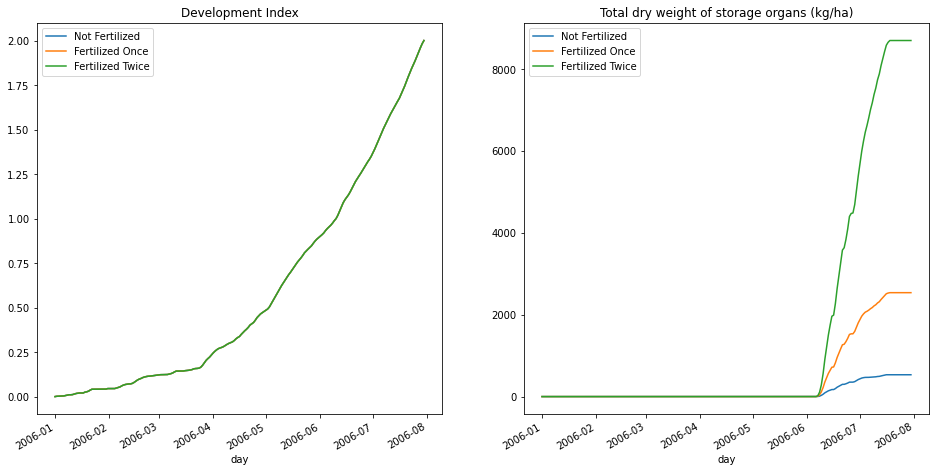

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df['DVS'].plot(ax=axes[0], title="Development Index", label='Not Fertilized')
df_fertilize['DVS'].plot(ax=axes[0], title="Development Index", label='Fertilized Once')
df_fertilize_more['DVS'].plot(ax=axes[0], title="Development Index", label='Fertilized Twice')
axes[0].legend()

# Plot the TWSO
df['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Not Fertilized')
df_fertilize['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Fertilized Once')
df_fertilize_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                               label='Fertilized Twice')
axes[1].legend()

fig.autofmt_xdate()

Now, let us plot see these difference in the nutrient availability of the soil.

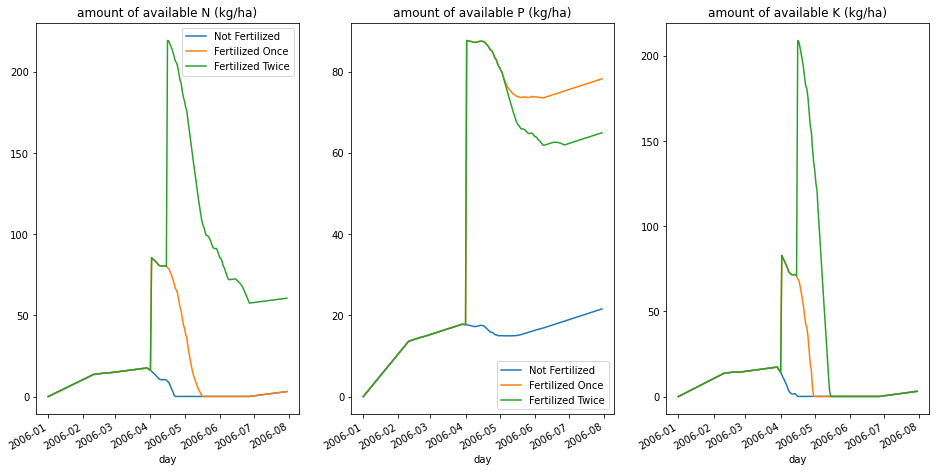

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Plot N Availability
df['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Not Fertilized')
df_fertilize['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Fertilized Once')
df_fertilize_more['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Fertilized Twice')
axes[0].legend()

# Plot P Availability
df['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Not Fertilized')
df_fertilize['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Fertilized Once')
df_fertilize_more['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Fertilized Twice')
axes[1].legend()

# Plot K Availability
df['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Not Fertilized')
df_fertilize['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Fertilized Once')
df_fertilize_more['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Fertilized Twice')
axes[0].legend()

fig.autofmt_xdate()

K is still goibg back to 0. We can try even more fertilization!

In [19]:
agro_file_name = "agro-fertilize-3x.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_fertilize_3x = pd.DataFrame(wofost.get_output())
df_fertilize_3x = df_fertilize_3x.set_index("day")
df_fertilize_3x[key_params].tail()

,DVS,TWSO,SM,WWLOW,NAVAIL,PAVAIL,KAVAIL
day,,,,,,,
2006-07-26,1.91155,9267.251872,0.347229,41.667512,52.011719,63.16541,44.22576
2006-07-27,1.93765,9267.251872,0.346154,41.538426,52.102719,63.25641,44.31676
2006-07-28,1.95970,9267.251872,0.345637,41.476399,52.193719,63.34741,44.40776
2006-07-29,1.98220,9267.251872,0.345904,41.508421,52.284719,63.43841,44.49876
2006-07-30,2.00000,9267.251872,0.344620,41.354341,52.375719,63.52941,44.58976


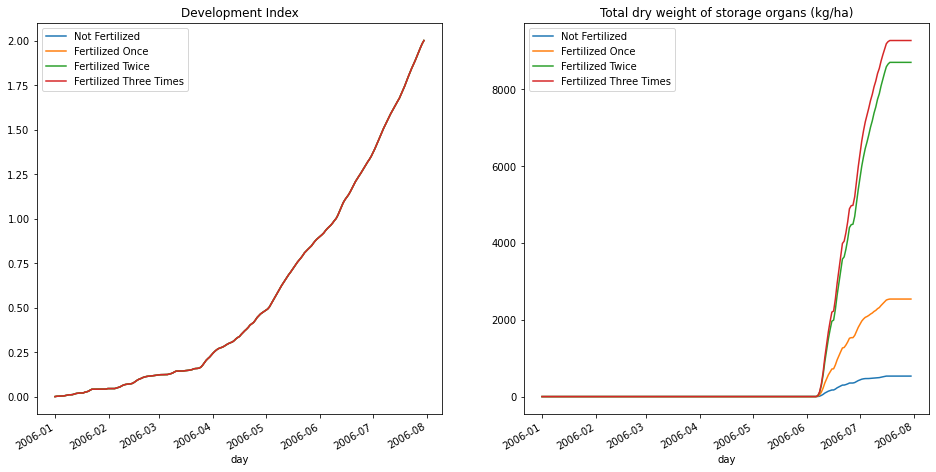

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

df['DVS'].plot(ax=axes[0], title="Development Index", label='Not Fertilized')
df_fertilize['DVS'].plot(ax=axes[0], title="Development Index", label='Fertilized Once')
df_fertilize_more['DVS'].plot(ax=axes[0], title="Development Index", label='Fertilized Twice')
df_fertilize_3x['DVS'].plot(ax=axes[0], title="Development Index", label='Fertilized Three Times')
axes[0].legend()

df['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Not Fertilized')
df_fertilize['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Fertilized Once')
df_fertilize_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                               label='Fertilized Twice')
df_fertilize_3x['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                               label='Fertilized Three Times')
axes[1].legend()

fig.autofmt_xdate()

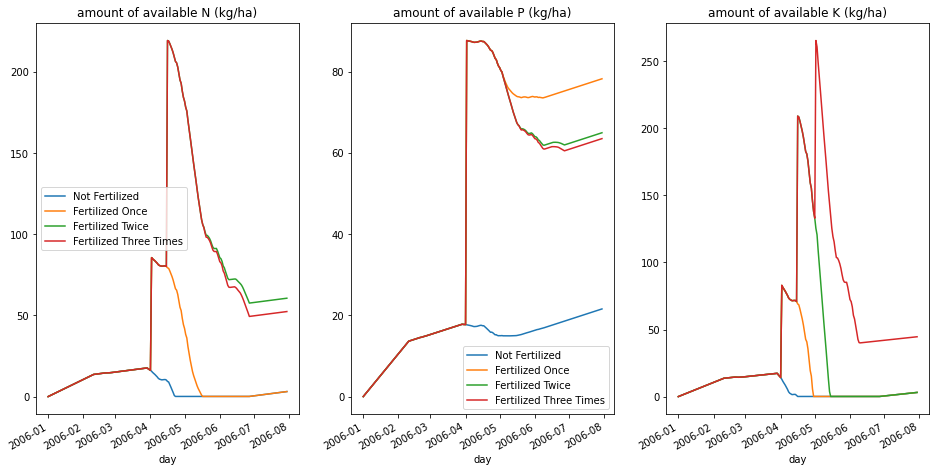

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Plot N Availability
df['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Not Fertilized')
df_fertilize['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Fertilized Once')
df_fertilize_more['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Fertilized Twice')
df_fertilize_3x['NAVAIL'].plot(ax=axes[0], title="amount of available N (kg/ha)", label='Fertilized Three Times')
axes[0].legend()

# Plot P Availability
df['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Not Fertilized')
df_fertilize['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Fertilized Once')
df_fertilize_more['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Fertilized Twice')
df_fertilize_3x['PAVAIL'].plot(ax=axes[1], title="amount of available P (kg/ha)", label='Fertilized Three Times')
axes[1].legend()

# Plot K Availability
df['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Not Fertilized')
df_fertilize['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Fertilized Once')
df_fertilize_more['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Fertilized Twice')
df_fertilize_3x['KAVAIL'].plot(ax=axes[2], title="amount of available K (kg/ha)", label='Fertilized Three Times')
axes[0].legend()
fig.autofmt_xdate()

We had a small increase in the yield and it seems that nutrients are available in the soil during the entire campaign. It seems to be the case that they are not being a limiting factor aymore, stopping the crop from reaching its potential yield.

## The Weather Input

Let us now give a look at what constitutes *weather.xlsx*, which is the weather input file. Let us read it using Pandas.

In [22]:
weather_df = pd.read_excel('data/weather.xlsx', header=10, skiprows=[11])
weather_df = weather_df.set_index("DAY")
weather_df

,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
DAY,,,,,,,
2004-01-01,-999,-0.7,1.1,0.55,3.6,0.5,-999
2004-01-02,3888,-7.5,0.9,0.44,3.1,0.0,-999
2004-01-03,2074,-6.8,-0.5,0.45,1.8,0.0,-999
2004-01-04,1814,-3.6,5.9,0.66,3.2,2.5,-999
2004-01-05,1469,3.0,5.7,0.78,2.3,1.3,-999
...,...,...,...,...,...,...,...
2008-12-27,3542,-4.1,0.3,0.49,3.0,0.0,-999
2008-12-28,3024,-4.2,-0.1,0.49,2.9,0.0,-999
2008-12-29,3542,-5.4,0.3,0.45,2.5,0.0,-999


We can see it is a file containing a series of state variables for each day from Jan 1, 2004 to Dec 31, 2008.

The variables contained, for each day, are:

* IRRAD: Daily global radiation ($Jm^{-2}/day$)
* TMIN: Daily minimum temperature ($^oC$)
* TMAX: Daily maximum temperature ($^oC$)
* VAP: Mean daily vapour pressure ($hPa$)
* WIND: Mean daily wind speed at 2 m above ground level ($m/s$)
* RAIN: Precipitation (rainfall or water equivalent in case of snow or hail) ($cm/day$)
* SNOWDEPTH: Depth of snow cover (optional) ($cm$)

We know that water supply is a very important limiting factor in WOFOST. How would our crop do in a drier weather? 

The file *dry_weather.xlsx* is identical to *weather.xlsx*, except that the rainfall in each day is exactly 5 times smaller. Let us plot the rainfalls of both files for the crop campaign period (Jan-Aug, 2006) and see the difference.

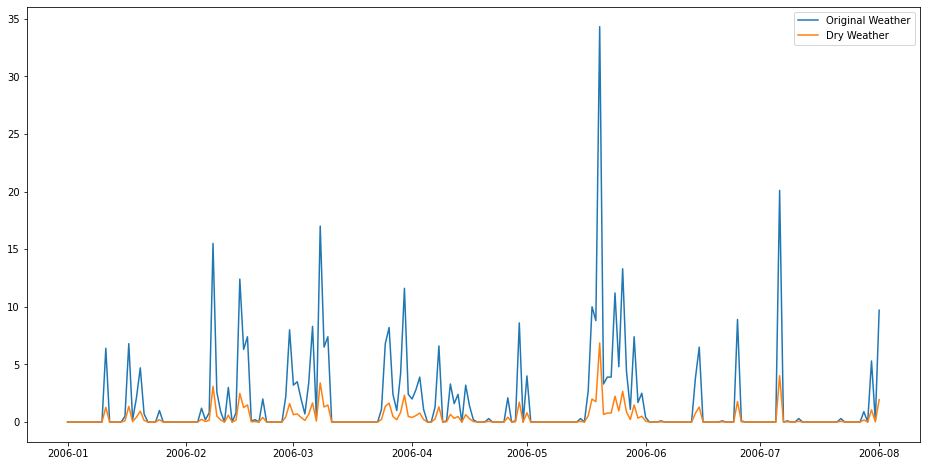

In [23]:
dry_weather_df = pd.read_excel('data/dry_weather.xlsx', header=10, skiprows=[11])
dry_weather_df = dry_weather_df.set_index("DAY")

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

plt.plot(weather_df['RAIN'].loc['2006-01-01':'2006-08-01'], label='Original Weather')
plt.plot(dry_weather_df['RAIN'].loc['2006-01-01':'2006-08-01'], label='Dry Weather')
plt.legend()
plt.show()

Let us give *dry_weather.xlsx* as the input file for our simulation and see how it affect crop development.

In [24]:
weather_file_name = "dry_weather.xlsx"
weatherdataprovider = ExcelWeatherDataProvider(os.path.join(data_dir, weather_file_name))
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_dry = pd.DataFrame(wofost.get_output())
df_dry = df_dry.set_index("day")
df_dry[key_params].tail()

,DVS,TWSO,SM,WWLOW,NAVAIL,PAVAIL,KAVAIL
day,,,,,,,
2006-07-26,1.91155,5744.111451,0.310335,37.240172,53.710683,63.409208,44.22576
2006-07-27,1.93765,5744.111451,0.310073,37.208751,53.801683,63.500208,44.31676
2006-07-28,1.95970,5744.111451,0.309917,37.190011,53.892683,63.591208,44.40776
2006-07-29,1.98220,5744.111451,0.309924,37.190923,53.983683,63.682208,44.49876
2006-07-30,2.00000,5744.111451,0.309633,37.155905,54.074683,63.773208,44.58976


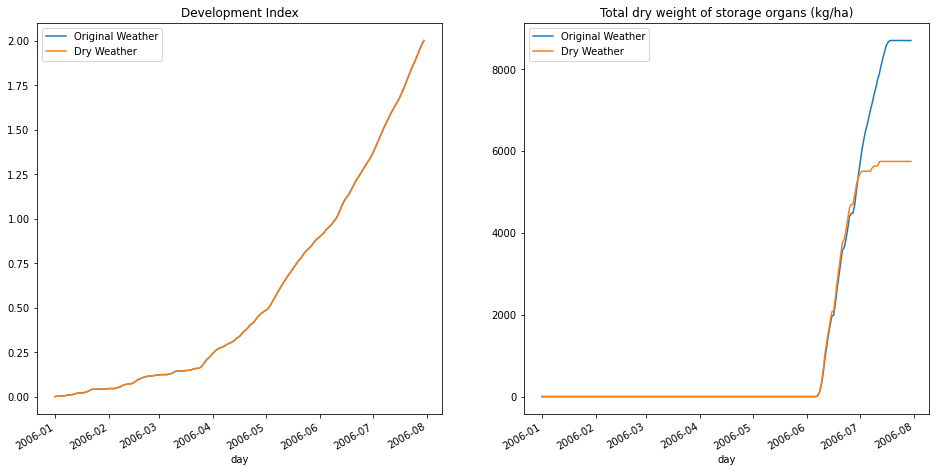

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df_fertilize_more['DVS'].plot(ax=axes[0], title="Development Index", label='Original Weather')
df_dry['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather')
axes[0].legend()

# Plot the TWSO
df_fertilize_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Original Weather')
df_dry['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather')
axes[1].legend()

fig.autofmt_xdate()

We can assume that the difference comes from the water availability. Let us plot soil moisture and amount of water in soil.

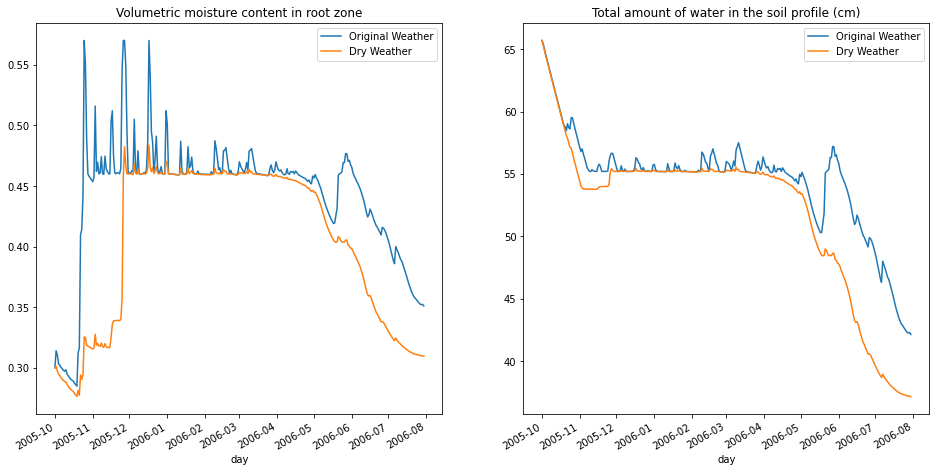

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot soil moisture
df_fertilize_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", label='Original Weather')
df_dry['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", label='Dry Weather')
axes[0].legend()

# Plot total amount of water
df_fertilize_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", label='Original Weather')
df_dry['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", label='Dry Weather')
axes[1].legend()

fig.autofmt_xdate()

### Applying Irrigation to compensate for dry weather

We can see that the main period with significant differences in soil moisture is after May, 2006. We could apply irrigation and see how it affects the crop development.

If you open the file *agro-irrigate.yaml*, you will se the following:

```YAML
Version: 1.0
AgroManagement:
- 2005-10-01:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2006-01-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name: Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - 2006-04-01: {N_amount: 100, P_amount: 100, K_amount: 100, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
        - 2006-04-15: {N_amount: 200, P_amount: 0, K_amount: 200, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
        - 2006-05-01: {N_amount: 0, P_amount: 0, K_amount: 200, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 2006-05-01: {amount: 10, efficiency: 0.7}
    StateEvents: null
```

We are applying 10cm of irrigation on May 1, 2006. Let us give this file as input to WOFOST and see how our simulation is affected.

In [27]:
agro_file_name = "agro-fertilize-irrigate.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_dry_irrigate = pd.DataFrame(wofost.get_output())
df_dry_irrigate = df_dry_irrigate.set_index("day")
df_dry_irrigate[key_params].tail()

,DVS,TWSO,SM,WWLOW,NAVAIL,PAVAIL,KAVAIL
day,,,,,,,
2006-07-26,1.91155,8005.30921,0.319164,38.299695,52.011719,63.16541,44.22576
2006-07-27,1.93765,8005.30921,0.318698,38.243796,52.102719,63.25641,44.31676
2006-07-28,1.95970,8005.30921,0.318420,38.210377,52.193719,63.34741,44.40776
2006-07-29,1.98220,8005.30921,0.318318,38.198146,52.284719,63.43841,44.49876
2006-07-30,2.00000,8005.30921,0.317922,38.150658,52.375719,63.52941,44.58976


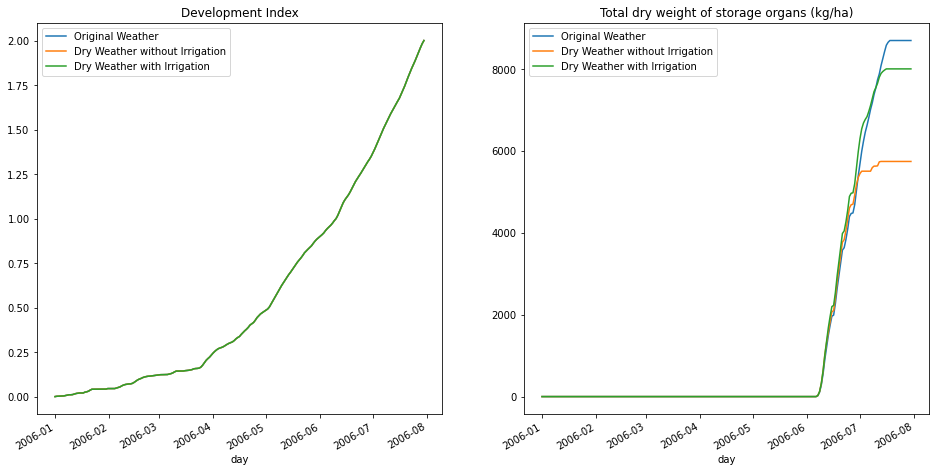

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df_fertilize_more['DVS'].plot(ax=axes[0], title="Development Index", label='Original Weather')
df_dry['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather without Irrigation')
df_dry_irrigate['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather with Irrigation')
axes[0].legend()

# Plot the TWSO
df_fertilize_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Original Weather')
df_dry['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather without Irrigation')
df_dry_irrigate['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather with Irrigation')
axes[1].legend()

fig.autofmt_xdate()

Let us plot and see how the water in the soil was affected by the irrigation.

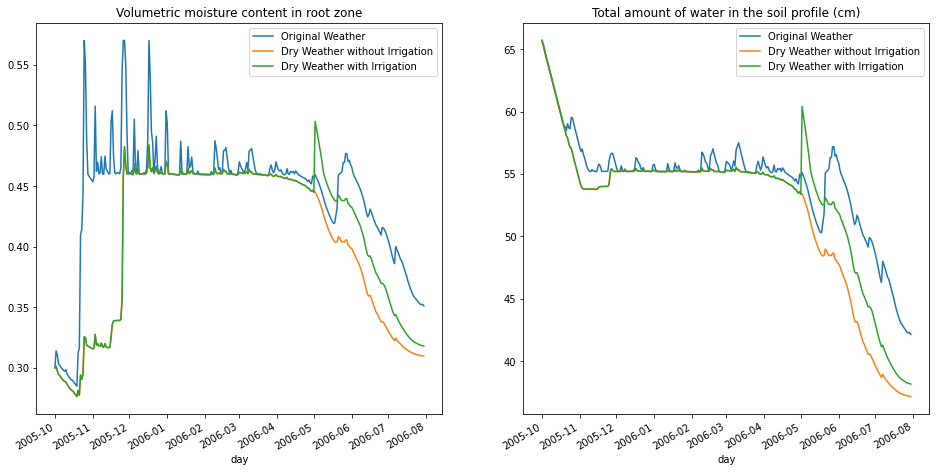

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot soil moisture
df_fertilize_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                             label='Original Weather')
df_dry['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                  label='Dry Weather without Irrigation')
df_dry_irrigate['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                           label='Dry Weather with Irrigation')
axes[0].legend()

# Plot total amount of water
df_fertilize_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                                label='Original Weather')
df_dry['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather without Irrigation')
df_dry_irrigate['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather with Irrigation')
axes[1].legend()

fig.autofmt_xdate()

There is still a gap in the total yield, and the soil moisture is still significantly below that in the original weatherafter half May. 

Let us add a second irrigation 15 days after the first.

If you open the file *agro-fertilize-irrigate-more.yaml* you will see the following:

```YAML
Version: 1.0
AgroManagement:
- 2005-10-01:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2006-01-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name: Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - 2006-04-01: {N_amount: 100, P_amount: 100, K_amount: 100, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
        - 2006-04-15: {N_amount: 200, P_amount: 0, K_amount: 200, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
        - 2006-05-01: {N_amount: 0, P_amount: 0, K_amount: 200, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
    -   event_signal: irrigate
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 2006-05-01: {amount: 10, efficiency: 0.7}
        - 2006-05-15: {amount: 10, efficiency: 0.7}
    StateEvents: null
```

Let us use this file as input to WOFOST and see how it affects the crop development.

In [30]:
agro_file_name = "agro-fertilize-irrigate-more.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_dry_irrigate_more = pd.DataFrame(wofost.get_output())
df_dry_irrigate_more = df_dry_irrigate_more.set_index("day")
df_dry_irrigate_more[key_params].tail()

,DVS,TWSO,SM,WWLOW,NAVAIL,PAVAIL,KAVAIL
day,,,,,,,
2006-07-26,1.91155,8936.238928,0.327234,39.268133,52.011719,63.16541,44.22576
2006-07-27,1.93765,8936.238928,0.326636,39.196366,52.102719,63.25641,44.31676
2006-07-28,1.95970,8936.238928,0.326275,39.153027,52.193719,63.34741,44.40776
2006-07-29,1.98220,8936.238928,0.326104,39.132456,52.284719,63.43841,44.49876
2006-07-30,2.00000,8936.238928,0.325653,39.078392,52.375719,63.52941,44.58976


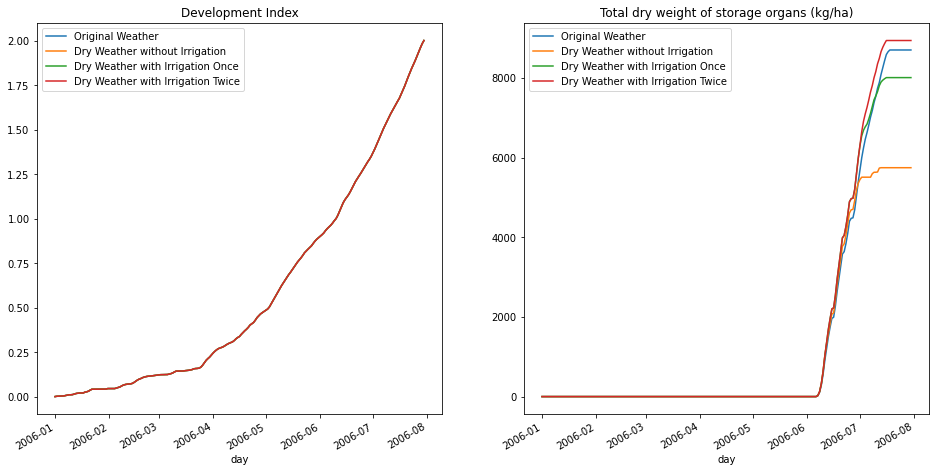

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df_fertilize_more['DVS'].plot(ax=axes[0], title="Development Index", label='Original Weather')
df_dry['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather without Irrigation')
df_dry_irrigate['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather with Irrigation Twice')
axes[0].legend()

# Plot the TWSO
df_fertilize_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Original Weather')
df_dry['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather without Irrigation')
df_dry_irrigate['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather with Irrigation Twice')
axes[1].legend()

fig.autofmt_xdate()

We can see that we are now producing more than with the original weather! Let us see how soil moisture was affected.

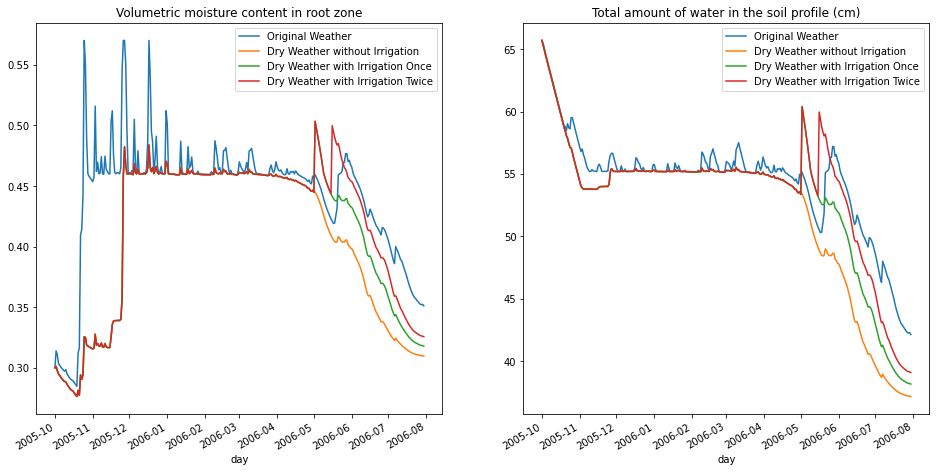

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot soil moisture
df_fertilize_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                             label='Original Weather')
df_dry['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                  label='Dry Weather without Irrigation')
df_dry_irrigate['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                           label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                           label='Dry Weather with Irrigation Twice')
axes[0].legend()

# Plot total amount of water
df_fertilize_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                                label='Original Weather')
df_dry['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather without Irrigation')
df_dry_irrigate['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather with Irrigation Twice')
axes[1].legend()

fig.autofmt_xdate()

### Reflection on Limiting Factors

In the last time we checked, water was not a limiting factor in the original weather. How is it then that now irrigation can make us achieve higher production than that of the original weather?

Let us see the water availability levels in our first crop, without fertilization, and in our last crop with the original weather, with fertilization.

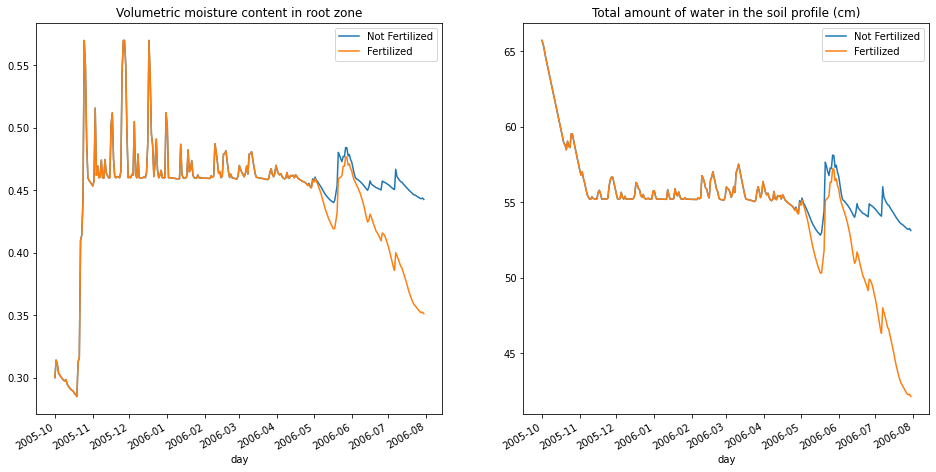

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot soil moisture
df['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                             label='Not Fertilized')
df_fertilize_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                  label='Fertilized')
axes[0].legend()

# Plot total amount of water
df['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                                label='Not Fertilized')
df_fertilize_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Fertilized')
axes[1].legend()

fig.autofmt_xdate()

We can see that applying fertilization led to much lower levels of water availability, especially after mid April.

What happened here?

The fertilization led to a greater crop growth, and the plants used more of the water available in the soil.
Water was not a limiting factor for small plants, but it is now with larger plants. 

Let us try to address this problem with a different type of agromanagement events.

## Agromanagement State Events

Until now, all of our agromanagement were conditioned on a date in which they should happen.

However, we can also condition events on some state variable of our simulation.

We can, for example, apply irrigation whenever we think that the soil needs water!

If you open the file *agro-conditional-irrigation.yaml*, you will see the following:

```YAML
Version: 1.0
AgroManagement:
- 2005-10-01:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2006-01-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents:
    -   event_signal: apply_npk
        name: Timed N/P/K application table
        comment: All fertilizer amounts in kg/ha
        events_table:
        - 2006-04-01: {N_amount: 100, P_amount: 100, K_amount: 100, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
        - 2006-04-15: {N_amount: 200, P_amount: 0, K_amount: 200, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
        - 2006-05-01: {N_amount: 0, P_amount: 0, K_amount: 200, N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}
    StateEvents:
    -   event_signal: irrigate
        event_state: SM
        zero_condition: falling
        name: irrigation scheduling on volumetric soil moisture content
        comment: all irrigation amounts in cm
        events_table:
        - 0.45: {amount: 2, efficiency: 0.7}
- 2006-08-01:
```

In this agromanagement file, we have a *State Event*. 

The event state tells the model which state variable to keep track of in order to define when the event should happen.

In the *events_table*, the keys define which values for the state variable trigger which events.

The *zero_condition* tell us from which direction the desired state value must be achieved in order to trigger the event. We have the following possibilities:
* rising: Triggers the event when the sate variable goes from below the target value to above the target value
* falling: Triggers the event when the state variable goes from above the target value to above the target value
* either: Trigger the event whenver the state variable crosses the target value from any direction

Our zero condition is *falling*. Therefore, whenever soil moisture goes from above 0.45 to below 0.45, an irrigation event is triggered, with an amount of water of 2cm.

Another small detail is that when we use state events, we need to add an empty new campaign after it.

Let us feed this agromanagement file to the mdoel and see how our crop development is affected.

In [34]:
agro_file_name = "agro-conditional-irrigation.yaml"
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_dry_conditional_irrigation = pd.DataFrame(wofost.get_output())
df_dry_conditional_irrigation = df_dry_conditional_irrigation.set_index("day")
df_dry_conditional_irrigation[key_params].tail()

,DVS,TWSO,SM,WWLOW,NAVAIL,PAVAIL,KAVAIL
day,,,,,,,
2006-07-28,1.9597,9267.251872,0.449595,53.951374,52.193719,63.34741,44.40776
2006-07-29,1.9822,9267.251872,0.460657,55.278830,52.284719,63.43841,44.49876
2006-07-30,2.0000,9267.251872,0.457629,54.915509,52.375719,63.52941,44.58976
2006-07-31,NaN,NaN,0.457341,54.880898,NaN,NaN,NaN
2006-08-01,NaN,NaN,0.434943,54.656923,NaN,NaN,NaN


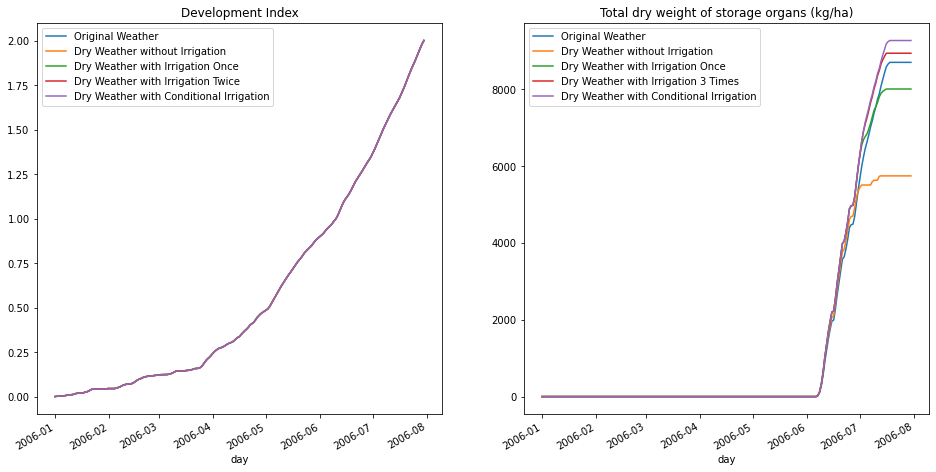

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot the DVS
df_fertilize_more['DVS'].plot(ax=axes[0], title="Development Index", label='Original Weather')
df_dry['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather without Irrigation')
df_dry_irrigate['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather with Irrigation Twice')
df_dry_conditional_irrigation['DVS'].plot(ax=axes[0], title="Development Index", label='Dry Weather with Conditional Irrigation')
axes[0].legend()

# Plot the TWSO
df_fertilize_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", label='Original Weather')
df_dry['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather without Irrigation')
df_dry_irrigate['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather with Irrigation 3 Times')
df_dry_conditional_irrigation['TWSO'].plot(ax=axes[1], title="Total dry weight of storage organs (kg/ha)", 
                          label='Dry Weather with Conditional Irrigation')
axes[1].legend()

fig.autofmt_xdate()

Let us see how the water availability in the soil behaved using the conditional irrigation instead of the timed irriagations.

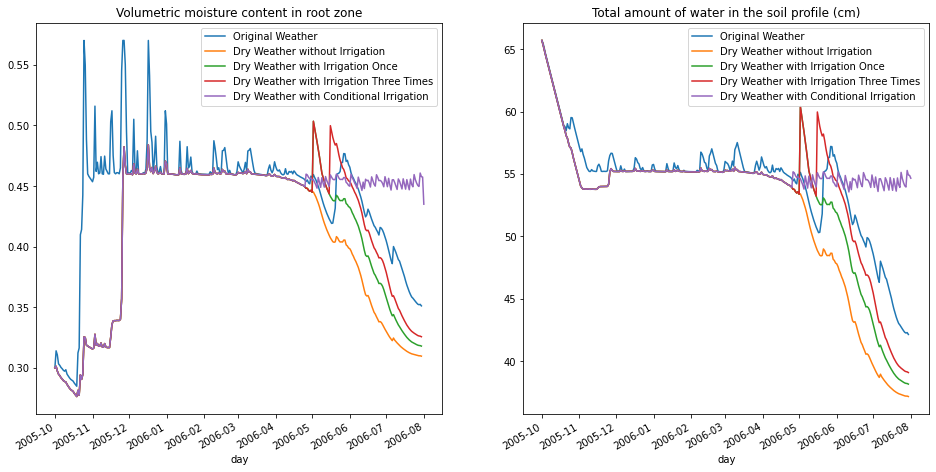

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

# Plot soil moisture
df_fertilize_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                             label='Original Weather')
df_dry['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                  label='Dry Weather without Irrigation')
df_dry_irrigate['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                           label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                           label='Dry Weather with Irrigation Three Times')
df_dry_conditional_irrigation['SM'].plot(ax=axes[0], title="Volumetric moisture content in root zone", 
                           label='Dry Weather with Conditional Irrigation')
axes[0].legend()

# Plot total amount of water
df_fertilize_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                                label='Original Weather')
df_dry['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather without Irrigation')
df_dry_irrigate['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather with Irrigation Once')
df_dry_irrigate_more['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather with Irrigation Three Times')
df_dry_conditional_irrigation['WWLOW'].plot(ax=axes[1], title="Total amount of water in the soil profile (cm)", 
                     label='Dry Weather with Conditional Irrigation')
axes[1].legend()

fig.autofmt_xdate()

## The Soil and Site Files

To finish our overview of the inputs to WOFOST, we will just give a look at the Soil and Site files.

The soil in WaterbalaceFD, which we are using is simulated as a two layer model: the rooted soil until the depth of the roots, and the region immediately below the root roze. When the roots reach maximum rooting depth, the soil is considered as a single layer.

If you open soil.cab, you will find the following:
```CABO
** $Id: ec4.new 1.2 1997/09/18 17:33:54 LEM release $
**
** SOIL DATA FILE for use with WOFOST Version 5.0, June 1990
**
** EC-4 fine

SOLNAM='EC4-fine'

** physical soil characteristics 

** soil water retention
SMW      =   0.300  !  soil moisture content at wilting point [cm3/cm3]
SMFCF    =   0.460  !  soil moisture content at field capacity [cm3/cm3]
SM0      =   0.570  !  soil moisture content at saturation [cm3/cm3]
CRAIRC   =   0.050  !  critical soil air content for aeration [cm3/cm3]

** hydraulic conductivity
RDMSOL   =  120.       ! soil maximum rootable depth
K0       =  10.789  ! hydraulic conductivity of saturated soil [cm day-1]
SOPE     =   0.55   ! maximum percolation rate root zone[cm day-1]
KSUB     =   0.37   ! maximum percolation rate subsoil [cm day-1]
```

### Soil Water Retention

The main variables that play roles in the soil water retention are:

* SMW: The soil moisture level below which plants wilt due to lack of pressure for water absorption
* SMFCF: The soil moisture at field capacity, the amount of water that the soil can "naturally" retain
* SM0: The soil moisture level at which the soil is saturated

Let us show how different values for the soil water retention variables affect the water availability during our campaign.

In [37]:
agro_file_name = "agro-fertilize-irrigate-more.yaml"
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_standard_soil = pd.DataFrame(wofost.get_output())
df_standard_soil = df_standard_soil.set_index("day")

# Higher SMW
soil['SMW'] = 0.4
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_smw = pd.DataFrame(wofost.get_output())
df_high_smw = df_high_smw.set_index("day")

# Higher SMFCF
soil['SMW'] = 0.3
soil['SMFCF'] = 0.5
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_smfcf = pd.DataFrame(wofost.get_output())
df_high_smfcf = df_high_smfcf.set_index("day")

# Lower SM0
soil['SMFCF'] = 0.46
soil['SM0'] = 0.48
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_low_sm0 = pd.DataFrame(wofost.get_output())
df_low_sm0 = df_low_sm0.set_index("day")

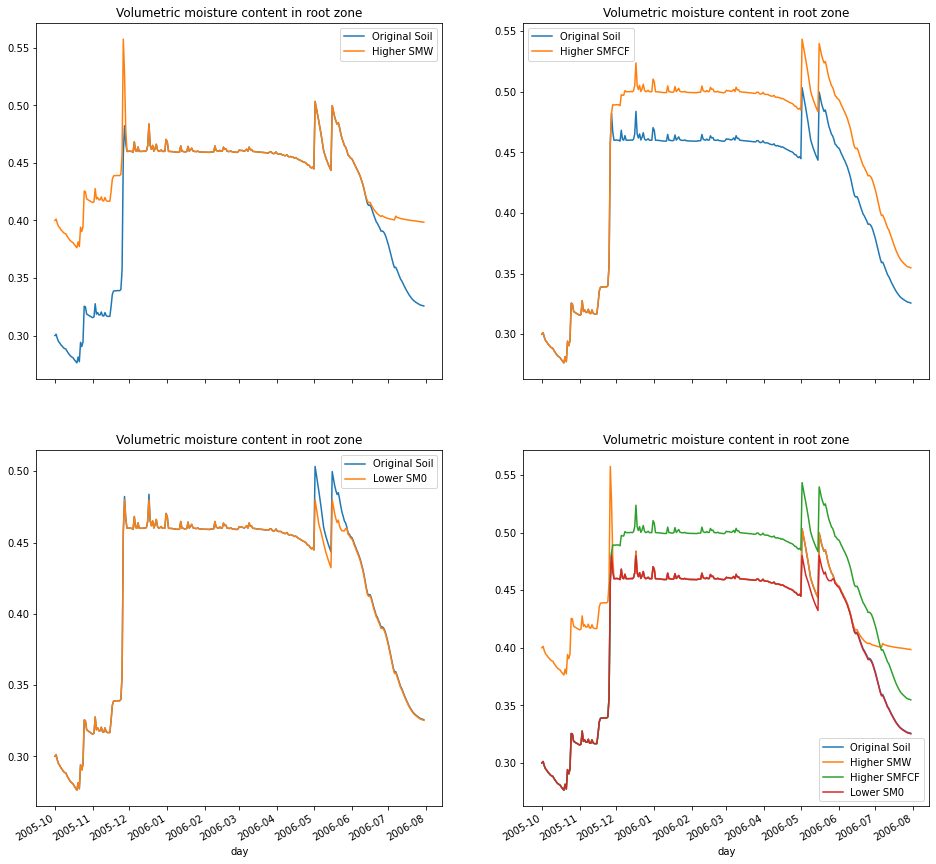

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

# Plot soil moisture
df_standard_soil['SM'].plot(ax=axes[0][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_smw['SM'].plot(ax=axes[0][0], title="Volumetric moisture content in root zone", 
                  label='Higher SMW')
axes[0][0].legend()


df_standard_soil['SM'].plot(ax=axes[0][1], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_smfcf['SM'].plot(ax=axes[0][1], title="Volumetric moisture content in root zone", 
                  label='Higher SMFCF')
axes[0][1].legend()


df_standard_soil['SM'].plot(ax=axes[1][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_low_sm0['SM'].plot(ax=axes[1][0], title="Volumetric moisture content in root zone", 
                  label='Lower SM0')
axes[1][0].legend()

df_standard_soil['SM'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_smw['SM'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                  label='Higher SMW')
df_high_smfcf['SM'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                  label='Higher SMFCF')
df_low_sm0['SM'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                  label='Lower SM0')
axes[1][1].legend()

fig.autofmt_xdate()

### Hydraulic Conductivity

The main variables that play roles in the hydraulic conductivity are:

* SOPE: Water movement in the root zone
* KSUB: Water movement in the subsoil

Let us show how different values for the soil hydraulic conductivity variables affect the water availability during our campaign.

In [39]:
agro_file_name = "agro-fertilize-irrigate-more.yaml"

soil = CABOFileReader(os.path.join(data_dir, soil_file_name))
soil['SM0'] = 0.48
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_standard_soil = pd.DataFrame(wofost.get_output())
df_standard_soil = df_standard_soil.set_index("day")

# Lower SOPE
soil['SOPE'] = 0.01
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_low_sope = pd.DataFrame(wofost.get_output())
df_low_sope = df_low_sope.set_index("day")

# Lower KSUB
soil['SOPE'] = 0.55
soil['KSUB'] = 0.01
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_low_ksub = pd.DataFrame(wofost.get_output())
df_low_ksub = df_low_ksub.set_index("day")

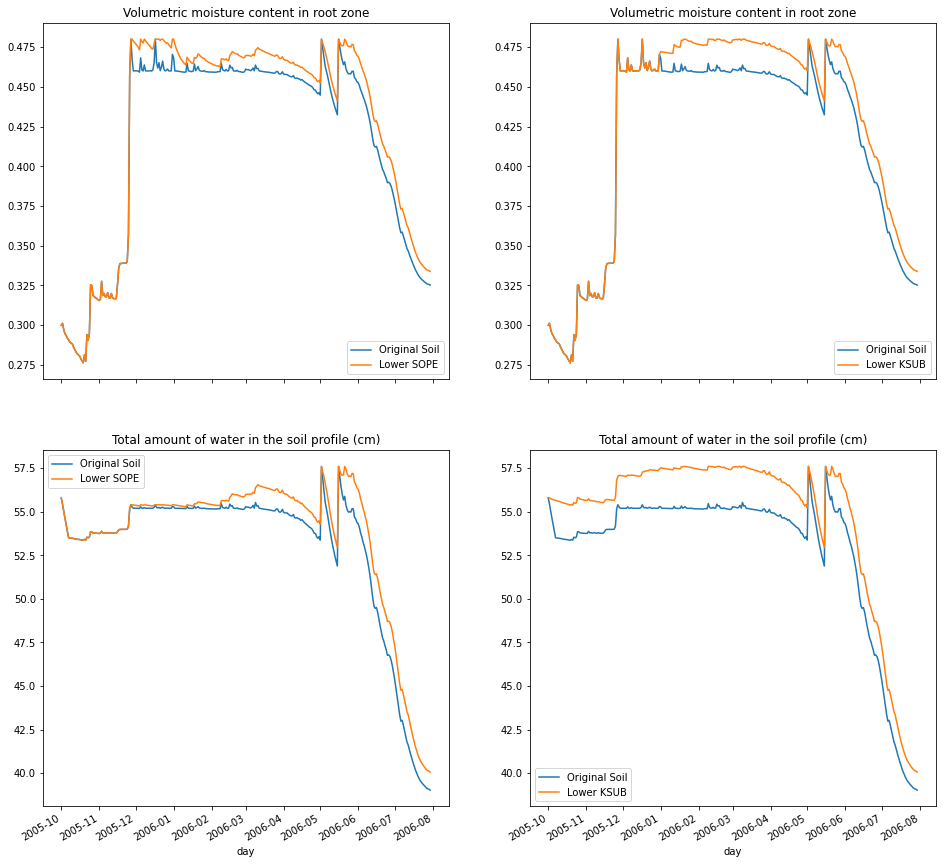

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

# Plot soil moisture

df_standard_soil['SM'].plot(ax=axes[0][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_low_sope['SM'].plot(ax=axes[0][0], title="Volumetric moisture content in root zone", 
                  label='Lower SOPE')
axes[0][0].legend()


df_standard_soil['SM'].plot(ax=axes[0][1], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_low_ksub['SM'].plot(ax=axes[0][1], title="Volumetric moisture content in root zone", 
                  label='Lower KSUB')
axes[0][1].legend()

# Plot soil moisture

df_standard_soil['WWLOW'].plot(ax=axes[1][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_low_sope['WWLOW'].plot(ax=axes[1][0], title="Total amount of water in the soil profile (cm)", 
                  label='Lower SOPE')
axes[1][0].legend()


df_standard_soil['WWLOW'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_low_ksub['WWLOW'].plot(ax=axes[1][1], title="Total amount of water in the soil profile (cm)", 
                  label='Lower KSUB')
axes[1][1].legend()

fig.autofmt_xdate()

### Water Balance in Site File

The last input we will discuss here is the site file. It has some water balance and nutrinet availability parameters.

If you open the file *site.cab*, you will find the following:

```CAB
**
** Site characteristics file for Running WOFOST N/P/K
** Derived from management data file for use with LINTUL model (May 2011)
**

SMLIM = 0.3  ! Limiting amount of volumetric moisture in upper soil layer [-]
IFUNRN = 0   ! Rain infiltration as function of storm size [0/1]
SSMAX = 0.   ! Maximum surface storage [cm]
SSI = 0.     ! Initial surface storage [cm]
WAV = 50     ! Initial amount of soil water [cm]
NOTINF = 0.  ! Not infiltrating fraction of rainfall [0..1]

* Background supply of N [kg/ha/day]
BG_N_SUPPLY = 0.091
* Soil N mineralization
NSOILBASE   =     10.    ! total mineral soil N available at start of growth period [kg N/ha]
NSOILBASE_FR  =   0.025  ! fraction of soil mineral coming available per day [day-1]


* Background supply of P [kg/ha/day]
BG_P_SUPPLY = 0.091
* Soil P mineralization
PSOILBASE   =    10.     ! total mineral soil P available at start of growth period [kg P/ha]
PSOILBASE_FR  =   0.025  ! fraction of soil mineral coming available per day [day-1]

* Background supply of K [kg/ha/day]
BG_K_SUPPLY = 0.091
* Soil K mineralization
KSOILBASE   =    10.     ! total mineral soil K available at start of growth period [kg K/ha]
KSOILBASE_FR  =   0.025  ! fraction of soil mineral coming available per day [day-1]
```

Let us first change some of the key variables related to the Water Balance and see how the crop development is affected:

In [41]:
agro_file_name = "agro-fertilize-irrigate-more.yaml"
weather_file_name = "weather.xlsx"

soil = CABOFileReader(os.path.join(data_dir, soil_file_name))
site = CABOFileReader(os.path.join(data_dir, site_file_name))
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
weatherdataprovider = ExcelWeatherDataProvider(os.path.join(data_dir, weather_file_name))
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_standard_soil = pd.DataFrame(wofost.get_output())
df_standard_soil = df_standard_soil.set_index("day")

# Higher SMLIM
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['SMLIM'] = 1
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_smlim = pd.DataFrame(wofost.get_output())
df_high_smlim = df_high_smlim.set_index("day")

# Higher IFUNRN
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['IFUNRN'] = 1
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_ifunrn = pd.DataFrame(wofost.get_output())
df_high_ifunrn = df_high_ifunrn.set_index("day")

# Higher SSMAX
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['SSMAX'] = 100
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_ssmax = pd.DataFrame(wofost.get_output())
df_high_ssmax = df_high_ssmax.set_index("day")

# Higher SSI
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['SSI'] = 100
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_ssi = pd.DataFrame(wofost.get_output())
df_high_ssi = df_high_ssi.set_index("day")

# Higher WAV
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['WAV'] = 0
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_low_wav = pd.DataFrame(wofost.get_output())
df_low_wav = df_low_wav.set_index("day")

# Higher NOTINF
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['NOTINF'] = 1
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_notinf = pd.DataFrame(wofost.get_output())
df_high_notinf = df_high_notinf.set_index("day")

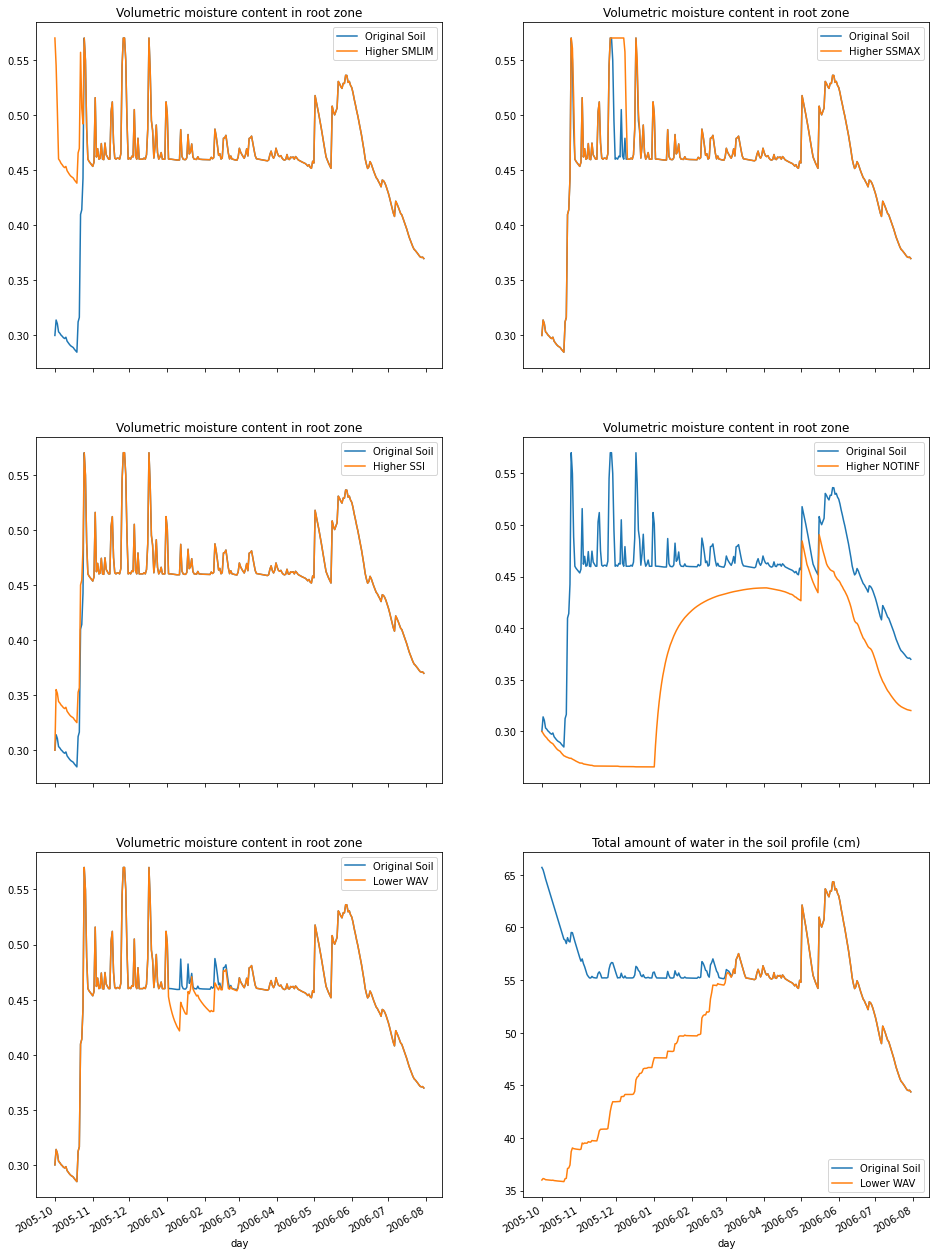

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,24))

# Plot soil moisture
df_standard_soil['SM'].plot(ax=axes[0][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_smlim['SM'].plot(ax=axes[0][0], title="Volumetric moisture content in root zone", 
                  label='Higher SMLIM')
axes[0][0].legend()


df_standard_soil['SM'].plot(ax=axes[0][1], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_ssmax['SM'].plot(ax=axes[0][1], title="Volumetric moisture content in root zone", 
                  label='Higher SSMAX')
axes[0][1].legend()


df_standard_soil['SM'].plot(ax=axes[1][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_ssi['SM'].plot(ax=axes[1][0], title="Volumetric moisture content in root zone", 
                  label='Higher SSI')
axes[1][0].legend()

df_standard_soil['SM'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_high_notinf['SM'].plot(ax=axes[1][1], title="Volumetric moisture content in root zone", 
                  label='Higher NOTINF')
axes[1][1].legend()


df_standard_soil['SM'].plot(ax=axes[2][0], title="Volumetric moisture content in root zone", 
                             label='Original Soil')
df_low_wav['SM'].plot(ax=axes[2][0], title="Volumetric moisture content in root zone", 
                  label='Lower WAV')
axes[2][0].legend()


df_standard_soil['WWLOW'].plot(ax=axes[2][1], title="Total amount of water in the soil profile (cm)", 
                             label='Original Soil')
df_low_wav['WWLOW'].plot(ax=axes[2][1], title="Total amount of water in the soil profile (cm)", 
                  label='Lower WAV')
axes[2][1].legend()


fig.autofmt_xdate()

### Nutrient Availability in Site File

Let us now look at how the site inpout affects the availability of nutrients in the soil. All three nutrients (N/P/k) have analogous mechanisms, so we will only focus on N.

In *site.cab*, we have the following definitions:

```CAB
* Background supply of N [kg/ha/day]
BG_N_SUPPLY = 0.091
* Soil N mineralization
NSOILBASE   =     10.    ! total mineral soil N available at start of growth period [kg N/ha]
NSOILBASE_FR  =   0.025  ! fraction of soil mineral coming available per day [day-1]
```

Let us change these variables and see how it affects the availability of N.

In [43]:
agro_file_name = "agro-fertilize-irrigate-more.yaml"

soil = CABOFileReader(os.path.join(data_dir, soil_file_name))
site = CABOFileReader(os.path.join(data_dir, site_file_name))
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)

wofost.run_till_terminate()
df_standard_soil = pd.DataFrame(wofost.get_output())
df_standard_soil = df_standard_soil.set_index("day")

# Higher BG_N_SUPPLY
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['BG_N_SUPPLY'] = 1
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_bg_n_supply = pd.DataFrame(wofost.get_output())
df_high_bg_n_supply = df_high_bg_n_supply.set_index("day")

# Higher NSOILBASE
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['NSOILBASE'] = 20
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_nsoilbase = pd.DataFrame(wofost.get_output())
df_high_nsoilbase = df_high_nsoilbase.set_index("day")

# Higher NSOILBASE_FR
site = CABOFileReader(os.path.join(data_dir, site_file_name))
site['NSOILBASE_FR'] = 1
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
wofost.run_till_terminate()
df_high_nsoilbase_fr = pd.DataFrame(wofost.get_output())
df_high_nsoilbase_fr = df_high_nsoilbase_fr.set_index("day")

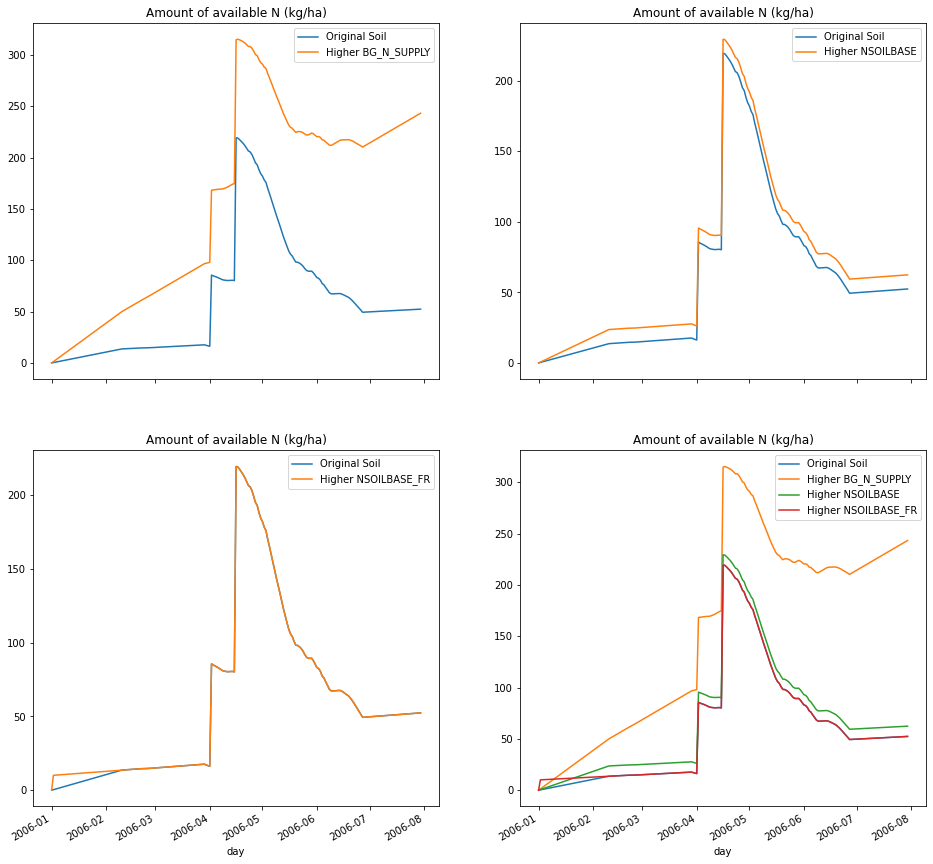

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

# Plot soil moisture
df_standard_soil['NAVAIL'].plot(ax=axes[0][0], title="Amount of available N (kg/ha)", 
                             label='Original Soil')
df_high_bg_n_supply['NAVAIL'].plot(ax=axes[0][0], label='Higher BG_N_SUPPLY')
axes[0][0].legend()


df_standard_soil['NAVAIL'].plot(ax=axes[0][1], title="Amount of available N (kg/ha)", 
                             label='Original Soil')
df_high_nsoilbase['NAVAIL'].plot(ax=axes[0][1], label='Higher NSOILBASE')
axes[0][1].legend()


df_standard_soil['NAVAIL'].plot(ax=axes[1][0], title="Amount of available N (kg/ha)", 
                             label='Original Soil')
df_high_nsoilbase_fr['NAVAIL'].plot(ax=axes[1][0], label='Higher NSOILBASE_FR')
axes[1][0].legend()


df_standard_soil['NAVAIL'].plot(ax=axes[1][1], title="Amount of available N (kg/ha)", 
                             label='Original Soil')
df_high_bg_n_supply['NAVAIL'].plot(ax=axes[1][1], label='Higher BG_N_SUPPLY')
df_high_nsoilbase['NAVAIL'].plot(ax=axes[1][1], label='Higher NSOILBASE')
df_high_nsoilbase_fr['NAVAIL'].plot(ax=axes[1][1], label='Higher NSOILBASE_FR')
axes[1][1].legend()

fig.autofmt_xdate()

## WOFOST for Data Science

Now that we have some knowledge about the the inputs and outputs of the model, let us see how we can use WOFOST to extract interesting statistics about crop development and how we can use them.

Let us try, for example, to extract simple weather statistics and evaluate their impact in the total yield.

Let us run the model for all 5 year available in the weather file and use it to generate yield data.

Let us use *agro-base.yaml* as our base agromanagement file to detrmine crop dates. If you open it, you will see the following:

```YAML
Version: 1.0
AgroManagement:
- 2004-01-02:
    CropCalendar:
        crop_name: wheat
        variety_name: winter-wheat
        crop_start_date: 2004-03-01
        crop_start_type: emergence
        crop_end_date: 
        crop_end_type: maturity
        max_duration: 300
    TimedEvents: null
    StateEvents: null
```

Let us create 5 different agromanagements, one for each year

In [45]:
agro_file_name = "agro-base.yaml"
base_agro = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                           Loader=yaml.SafeLoader)['AgroManagement']

base_agro

[{datetime.date(2004, 1, 2): {'CropCalendar': {'crop_name': 'wheat',
    'variety_name': 'winter-wheat',
    'crop_start_date': datetime.date(2004, 3, 1),
    'crop_start_type': 'emergence',
    'crop_end_date': None,
    'crop_end_type': 'maturity',
    'max_duration': 300},
   'TimedEvents': None,
   'StateEvents': None}}]

Let us give a look at how an agromanagement object is organized

```JSON
[
    {
        datetime.date(2004, 1, 2): {
            'CropCalendar': {
                'crop_name': 'wheat',
                'variety_name': 'winter-wheat',
                'crop_start_date': datetime.date(2004, 3, 1),
                'crop_start_type': 'emergence',
                'crop_end_date': None,
                'crop_end_type': 'maturity',
                'max_duration': 300
            },
           'TimedEvents': None,
           'StateEvents': None
        }
    }
]
```

In [46]:
from datetime import date
from copy import deepcopy

base_campaign = base_agro[0][date(2004, 1, 2)]

years = [2004, 2005, 2006, 2007, 2008]
agromanagements = {}
for year in years:
    current_campaign = deepcopy(base_campaign)
    current_campaign['CropCalendar']['crop_start_date'] = date(year,3, 1)
    agromanagements[year] = [{date(year,1,2): current_campaign}]
    
agromanagements

{2004: [{datetime.date(2004, 1, 2): {'CropCalendar': {'crop_name': 'wheat',
     'variety_name': 'winter-wheat',
     'crop_start_date': datetime.date(2004, 3, 1),
     'crop_start_type': 'emergence',
     'crop_end_date': None,
     'crop_end_type': 'maturity',
     'max_duration': 300},
    'TimedEvents': None,
    'StateEvents': None}}],
 2005: [{datetime.date(2005, 1, 2): {'CropCalendar': {'crop_name': 'wheat',
     'variety_name': 'winter-wheat',
     'crop_start_date': datetime.date(2005, 3, 1),
     'crop_start_type': 'emergence',
     'crop_end_date': None,
     'crop_end_type': 'maturity',
     'max_duration': 300},
    'TimedEvents': None,
    'StateEvents': None}}],
 2006: [{datetime.date(2006, 1, 2): {'CropCalendar': {'crop_name': 'wheat',
     'variety_name': 'winter-wheat',
     'crop_start_date': datetime.date(2006, 3, 1),
     'crop_start_type': 'emergence',
     'crop_end_date': None,
     'crop_end_type': 'maturity',
     'max_duration': 300},
    'TimedEvents': None,

In [47]:
weather_file_name = "dry_weather.xlsx"

soil = CABOFileReader(os.path.join(data_dir, soil_file_name))
site = CABOFileReader(os.path.join(data_dir, site_file_name))
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)
weatherdataprovider = ExcelWeatherDataProvider(os.path.join(data_dir, weather_file_name))

dfs = {}
for year in years:
    agromanagement = agromanagements[year]
    wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
    wofost.run_till_terminate()
    dfs[year] = pd.DataFrame(wofost.get_output())
    dfs[year] = dfs[year].set_index("day")
    
dfs[2006].tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,...,KDEMRT,KDEMSO,KDEMST,RNUPTAKE,RPUPTAKE,RKUPTAKE,RNFIX,NTRANSLOCATABLE,PTRANSLOCATABLE,KTRANSLOCATABLE
day,,,,,,,,,,,,,,,,,,,,,
2006-08-02,1.92955,0.019599,2477.228103,440.63064,777.779539,1258.817924,616.577494,0.001968,120.0,0.414763,...,0.0,0.098796,5.733690,0.0,0.0,0.0,0.0,15.376744,5.908091,19.585776
2006-08-03,1.94670,0.014813,2477.228103,440.63064,777.779539,1258.817924,616.577494,0.000985,120.0,0.414455,...,0.0,0.088917,5.486788,0.0,0.0,0.0,0.0,15.340519,5.902739,19.575897
2006-08-04,1.96280,0.007255,2477.228103,440.63064,777.779539,1258.817924,616.577494,0.000824,120.0,0.414246,...,0.0,0.080025,5.251648,0.0,0.0,0.0,0.0,15.307916,5.897923,19.567005
2006-08-05,1.98210,0.007255,2477.228103,440.63064,777.779539,1258.817924,616.577494,0.001038,120.0,0.417139,...,0.0,0.072022,5.007220,0.0,0.0,0.0,0.0,15.278574,5.893588,19.559002
2006-08-06,2.00000,0.002074,2477.228103,440.63064,777.779539,1258.817924,616.577494,0.000310,120.0,0.414039,...,0.0,0.064820,4.776118,0.0,0.0,0.0,0.0,15.252166,5.889687,19.551800


Now we have a dictionary with the simulation results for 5 different years.

Let us create a DataFrame with important statistics of the weather for each year and see how they relate to they yield.

Let us consider the averages of each variable as the important statistics.

In [48]:
columns = ['YEAR', 'TWSO', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN']
weather_columns = ['IRRAD', 'TMIN', 'TMAX', 'VAP', 'WIND', 'RAIN']
statistics_df = pd.DataFrame()

for year in years:
    new_row = {}
    new_row['YEAR'] = year
    new_row['TWSO'] = dfs[year].iloc[-1]['TWSO']
    
    for column in weather_columns:
        new_row[column] = dry_weather_df.loc[str(year):str(year)+'-08-01'][column].mean()
    
    statistics_df = statistics_df.append(new_row, ignore_index=True)

statistics_df['YEAR'] = pd.to_numeric(statistics_df['YEAR'], downcast='integer')
statistics_df

,IRRAD,RAIN,TMAX,TMIN,TWSO,VAP,WIND,YEAR
0,11860.406542,0.453178,14.216355,5.083645,502.255487,1.016000,2.956542,2004
1,12204.708920,0.453052,14.512676,5.538498,375.961602,1.037643,2.855399,2005
2,12446.483568,0.367512,14.336150,5.262911,440.630640,1.003488,2.782160,2006
3,11664.812207,0.639249,16.046479,7.115493,387.276171,1.149685,3.050235,2007
4,12143.654206,0.472150,15.186916,6.339252,740.173046,1.115650,3.158879,2008


Now that our simple dataset is ready, we can do some data analysis and see what it tells us about the main factors of influence of weather on a crop.

Let us try to run a linear regression and figure out the beta and $R^2$ for TMAX

In [49]:
import statsmodels.api as sm

X = statistics_df[['TMAX']]
y = statistics_df['TWSO']
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

/Users/rogerio/opt/anaconda3/envs/py3_pcse/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TWSO   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.331
Method:                 Least Squares   F-statistic:                  0.004456
Date:                Wed, 23 Sep 2020   Prob (F-statistic):              0.951
Time:                        09:23:44   Log-Likelihood:                -31.551
No. Observations:                   5   AIC:                             67.10
Df Residuals:                       3   BIC:                             66.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.4437   1676.884      0.225      0.836   -4959.150    5714.037
TMAX           7.5248    112.729      0.067      0.951    -351.229     366.279
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.743
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.971
Skew:                           1.063   Prob(JB):                        0.615
Kurtosis:                       2.622   Cond. No.                         326.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, let us try to rdo the same for RAIN

In [50]:
##### YOUR CODE HERE #####

X = statistics_df[['RAIN']]
y = statistics_df['TWSO']
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

##########################

/Users/rogerio/opt/anaconda3/envs/py3_pcse/lib/python3.6/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TWSO   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.295
Method:                 Least Squares   F-statistic:                   0.08881
Date:                Wed, 23 Sep 2020   Prob (F-statistic):              0.785
Time:                        09:23:44   Log-Likelihood:                -31.481
No. Observations:                   5   AIC:                             66.96
Df Residuals:                       3   BIC:                             66.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        610.5283    413.917      1.475      0.237    -706.742    1927.798
RAIN        -254.2177    853.028     -0.298      0.785   -2968.935    2460.499
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.328
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.142
Skew:                           1.166   Prob(JB):                        0.565
Kurtosis:                       2.785   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We could also extrapolate the expected yield and its standard deviation from those 5 years

In [51]:
print("Expected yield:", statistics_df['TWSO'].mean())
print("Standard Deviation:", statistics_df['TWSO'].std())

Expected yield: 489.2593892979474
Standard Deviation: 148.93646487685422


We can see that we have very few data points due to the small number of years in our weather data.

We can use a lot of small random variations to the weather of a given year to create ramdoness in the model and create confidence intervals for the yield of a given agromanagement strategy.

Let us try to create 100 variations of the weather in 2006!

In [52]:
def add_header(header, path):
    src = open(path,"r") 
    fline=header
    oline=src.readlines() 
    oline.insert(0,fline) 
    src.close() 

    src=open(path,"w") 
    src.writelines(oline) 
    src.close() 

In [53]:
import numpy as np

# This header is necessary for reading weather from CSV files in WOFOST

header = "## Site Characteristics\n"\
"Country     = 'Netherlands'\n"\
"Station     = 'Wageningen, Haarweg'\n"\
"Description = 'Observed data from Station Haarweg in Wageningen'\n"\
"Source      = 'Meteorology and Air Quality Group, Wageningen University'\n"\
"Contact     = 'Peter Uithol'\n"\
"Longitude = 5.67; Latitude = 51.97; Elevation = 7; AngstromA = 0.18; AngstromB = 0.55; HasSunshine = False\n"\
"## Daily weather observations (missing values are NaN)\n"

np.random.seed(999)
n_random_weathers = 100

standard_weather = dry_weather_df.loc["2004"].drop(['SNOWDEPTH'], axis=1)
random_weathers = []
n_days = len(standard_weather)
for idx in range(n_random_weathers):
    random_weathers.append(deepcopy(standard_weather))
    for column in random_weathers[idx].columns:
        rand_mu = np.random.normal(0, 0.5)
        mu = standard_weather[column].mean()
        sigma = standard_weather[column].std()
        random_weathers[idx][column] += rand_mu * mu
        for day in range(n_days):
            random_weathers[idx][column][day] += np.random.normal(0, sigma)
            if column not in ['TMIN', 'TMAX']:
                random_weathers[idx][column][day] = np.abs(random_weathers[idx][column][day])
            if column in ['IRRAD']:
                random_weathers[idx][column][day] = min(random_weathers[idx][column][day], 40000)
            if column in ['TMIN', 'TMAX']:
                random_weathers[idx][column][day] = min(random_weathers[idx][column][day], 60)
                random_weathers[idx][column][day] = max(random_weathers[idx][column][day], -50)
            if column in ['VAP']:
                random_weathers[idx][column][day] = min(random_weathers[idx][column][day], 199.3)
                random_weathers[idx][column][day] = max(random_weathers[idx][column][day], 0.06)
    random_weathers[idx]['SNOWDEPTH'] = np.nan
    weather_file_name = 'weather_' + str(idx).zfill(2) + '.csv'
    weather_file_path = os.path.join(data_dir, weather_file_name)
    random_weathers[idx].to_csv(weather_file_path, na_rep="NaN", date_format='%Y%m%d')
    add_header(header, os.path.join(data_dir, weather_file_path))
    if idx%10 == 9:
        print((idx+1)*(100/n_random_weathers), "% done!")

10.0 % done!
20.0 % done!
30.0 % done!
40.0 % done!
50.0 % done!
60.0 % done!
70.0 % done!
80.0 % done!
90.0 % done!
100.0 % done!


In [54]:
from pcse.fileinput import CSVWeatherDataProvider

rand_statistics_df = pd.DataFrame()

for idx in range(n_random_weathers):
    weather_file_name = "weather_" + str(idx).zfill(2) + ".csv"
    agro_file_name = "agro-base.yaml"
    agromanagement = yaml.load(open(os.path.join(data_dir, agro_file_name)), 
                               Loader=yaml.SafeLoader)['AgroManagement']

    weatherdataprovider = CSVWeatherDataProvider(os.path.join(data_dir, weather_file_name))

    wofost = Engine(parameterprovider, weatherdataprovider, agromanagement, config)
    wofost.run_till_terminate()

    output_df = pd.DataFrame(wofost.get_output())
    new_row['TWSO'] = output_df['TWSO'].iloc[-1]
    
    for column in weather_columns:
        weather_df = pd.read_csv(os.path.join(data_dir, weather_file_name), header=8)
        new_row[column] = weather_df[column].mean()
    
    rand_statistics_df = rand_statistics_df.append(new_row, ignore_index=True)
    if idx%10 == 9:
        print((idx+1)*(100/n_random_weathers), "% done!")
    
rand_statistics_df

10.0 % done!
20.0 % done!
30.0 % done!
40.0 % done!
50.0 % done!
60.0 % done!
70.0 % done!
80.0 % done!
90.0 % done!
100.0 % done!


,IRRAD,RAIN,TMAX,TMIN,TWSO,VAP,WIND,YEAR
0,12150.816516,0.908819,23.619077,-1.985814,360.772313,1.094977,2.090846,2008.0
1,12180.735558,0.912530,-7.476239,7.874089,22.122589,0.962811,3.050961,2008.0
2,9517.250935,1.191454,13.730066,2.426323,790.194077,0.436543,2.344419,2008.0
3,12805.807495,0.958346,18.527972,3.984812,929.923533,0.475500,1.988709,2008.0
4,15697.520090,1.104579,4.422032,4.204608,345.564223,1.879942,6.651994,2008.0
...,...,...,...,...,...,...,...,...
95,9365.753630,0.845410,10.372940,4.614900,686.484207,1.535707,1.849687,2008.0
96,13336.064877,0.922967,10.707787,10.989592,471.705414,2.051801,1.715577,2008.0
97,9802.966764,0.974372,4.960978,5.219440,430.724983,0.979393,2.861275,2008.0
98,10722.982826,0.914930,13.549418,4.327844,740.974477,1.216306,5.746985,2008.0


In [55]:
X = rand_statistics_df[weather_columns]
y = rand_statistics_df['TWSO']
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TWSO   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     12.68
Date:                Wed, 23 Sep 2020   Prob (F-statistic):           2.09e-10
Time:                        09:26:37   Log-Likelihood:                -668.30
No. Observations:                 100   AIC:                             1351.
Df Residuals:                      93   BIC:                             1369.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        464.0910    310.280      1.496      0.138    -152.064    1080.245
IRRAD         -0.0120      0.007     -1.744      0.085      -0.026       0.002
TMIN          -7.4841      6.559     -1.141      0.257     -20.510       5.541
TMAX          21.1053      2.775      7.606      0.000      15.595      26.616
VAP           36.7558     46.952      0.783      0.436     -56.481     129.992
WIND         -43.6465     20.660     -2.113      0.037     -84.673      -2.620
RAIN         187.5088    289.778      0.647      0.519    -387.933     762.951
==============================================================================
Omnibus:                       12.667   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.144
Skew:                          -0.219   Prob(JB):                     1.42e-08
Kurtosis:                       5.913   Cond. No.                     2.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
X = rand_statistics_df[['TMAX']]
y = rand_statistics_df['TWSO']
X = sm.add_constant(X)

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TWSO   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     62.42
Date:                Wed, 23 Sep 2020   Prob (F-statistic):           4.13e-12
Time:                        09:26:37   Log-Likelihood:                -673.54
No. Observations:                 100   AIC:                             1351.
Df Residuals:                      98   BIC:                             1356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        342.8443     45.633      7.513      0.000     252.288     433.401
TMAX          22.0442      2.790      7.901      0.000      16.507      27.581
==============================================================================
Omnibus:                       13.852   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               46.967
Skew:                          -0.159   Prob(JB):                     6.33e-11
Kurtosis:                       6.342   Cond. No.                         36.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

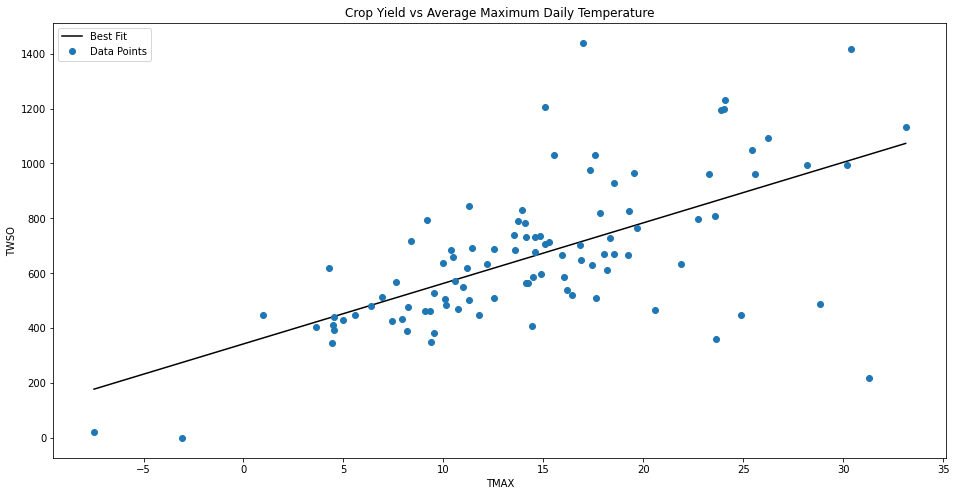

In [57]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

x = np.linspace(rand_statistics_df['TMAX'].min(), rand_statistics_df['TMAX'].max(), 500)

# Plot soil moisture
beta = model.params.TMAX
beta_0 = model.params.const
ax1.plot(x, x*beta+beta_0, color='black', label='Best Fit')
ax1.plot(rand_statistics_df['TMAX'], rand_statistics_df['TWSO'], ls="", marker='o', label='Data Points')

plt.xlabel('TMAX')
plt.ylabel('TWSO')

plt.title('Crop Yield vs Average Maximum Daily Temperature')

ax1.legend()

plt.show()